In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (14, 8)

# Weighted sum of distributions

In [24]:
from sklearn.utils import check_random_state

class composed_rv(object):
    def __init__(self, components, weights):
        self.components = components
        self.weights = weights
        
    def pdf(self, x):
        return sum(p_c.pdf(x) * w for p_c, w in zip(self.components, self.weights))
    
    def rvs(self, n_samples=1, random_state=None):
        random_state = check_random_state(random_state)
        
        _, c = np.where(random_state.multinomial(1, self.weights, n_samples) == 1)
        samples = []

        for i in range(n_samples):
            samples.append(self.components[c[i]].rvs(random_state=random_state))
            
        if len(samples) == 1:
            return samples[0]
        else:
            return np.array(samples)

# Toy data

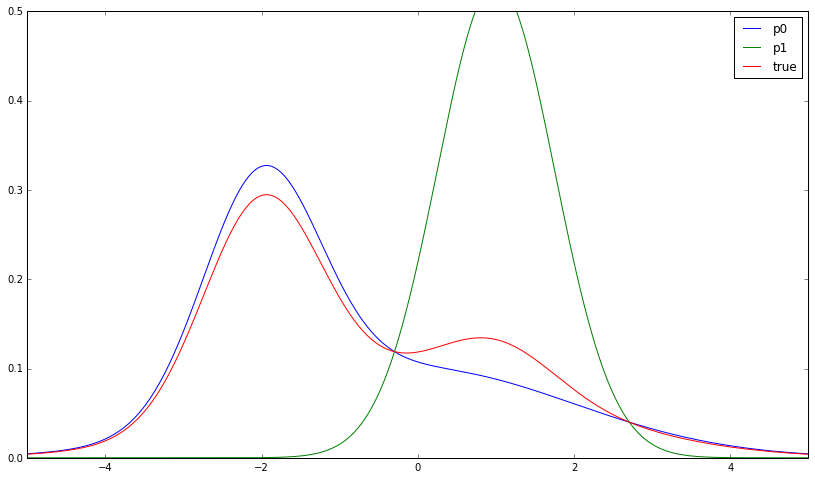

In [87]:
from scipy.stats import norm

# Define distributions
p0 = composed_rv([norm(loc=-2.0, scale=0.75), norm(loc=0.0, scale=2.0)], [0.5, 0.5])
p1 = norm(loc=1.0, scale=0.75)
theta = 0.1  # <= this is the parameter value we are looking for
true = composed_rv([p0, p1], [1 - theta, theta])

# Plot
x = np.linspace(-5, 5, num=1000)
plt.plot(x, p0.pdf(x), label="p0")
plt.plot(x, p1.pdf(x), label="p1")
plt.plot(x, true.pdf(x), label="true")
plt.xlim(-5, 5)
plt.ylim(0, 0.5)
plt.legend()
plt.show()

# $p_0$ and $p_1$ are known

In [93]:
def likelihood(theta, p0, p1, X, log=True):  
    # Likelihood of X ~ theta*p0 + (1-theta)*p1, up to a constant factor
    l = 0.0
    
    for x_i in X:
        x_i = x_i[0]
        l += np.log(theta * p1.pdf(x_i) / p0.pdf(x_i) + (1 - theta))

    return l if log else np.exp(l)

In [94]:
X_true = true.rvs(1000, random_state=0).reshape(-1, 1)
thetas = np.linspace(0., 1., num=201)
values = [likelihood(t, p0, p1, X_true) for t in thetas]
theta_max = np.argmax(values)
print("theta* = %.2f (L = %.2f)" % (thetas[theta_max], values[theta_max]))

theta* = 0.10 (L = 16.76)


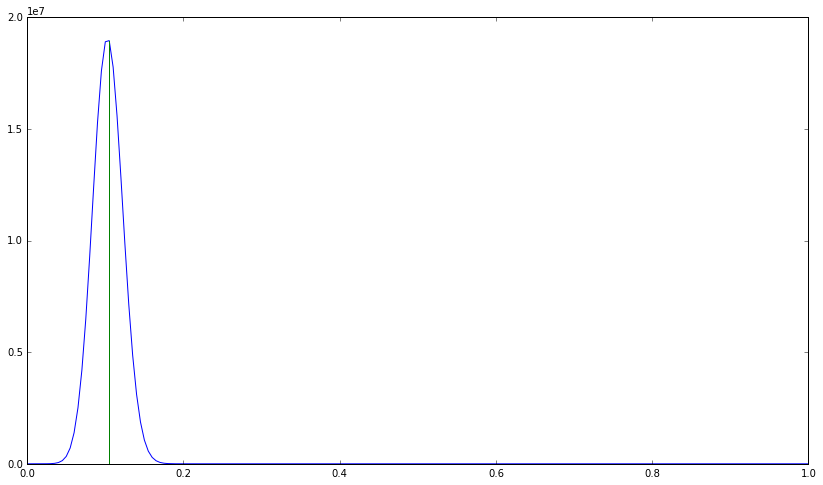

In [95]:
plt.plot(thetas, np.exp(values))
plt.plot([thetas[theta_max], thetas[theta_max]], [0, np.exp(values[theta_max])])
plt.show()

# $p_0$ and $p_1$ can be drawn from, excellent classifier

In [97]:
from sklearn.neural_network import MLPClassifier

n_samples = 10000  # Goodness is controlled by having many training samples
X_p0 = p0.rvs(n_samples, random_state=0).reshape(-1, 1)
X_p1 = p1.rvs(n_samples, random_state=0).reshape(-1, 1)
X = np.vstack((X_p0, X_p1))
y = np.ones(len(X), dtype=np.int)
y[:n_samples] = 0

clf = MLPClassifier()
clf.fit(X, y)

MLPClassifier(activation='relu', algorithm='adam', alpha=0.0001,
       batch_size=200, beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [98]:
def likelihood_clf(theta, X, clf, log=True):
    c = clf.predict_proba(X)[:, 1]
    
    l = 0.0
    for i in range(len(c)):
        l += np.log(theta * c[i] / (1 - c[i]) + (1 - theta))

    return l if log else np.exp(l)

In [100]:
X_true = true.rvs(1000, random_state=0).reshape(-1, 1)
thetas = np.linspace(0., 1., num=201)
values = [likelihood_clf(t, X_true, clf) for t in thetas]
theta_max = np.argmax(values)
print("theta* = %.2f (L = %.2f)" % (thetas[theta_max], values[theta_max]))

theta* = 0.10 (L = 16.65)


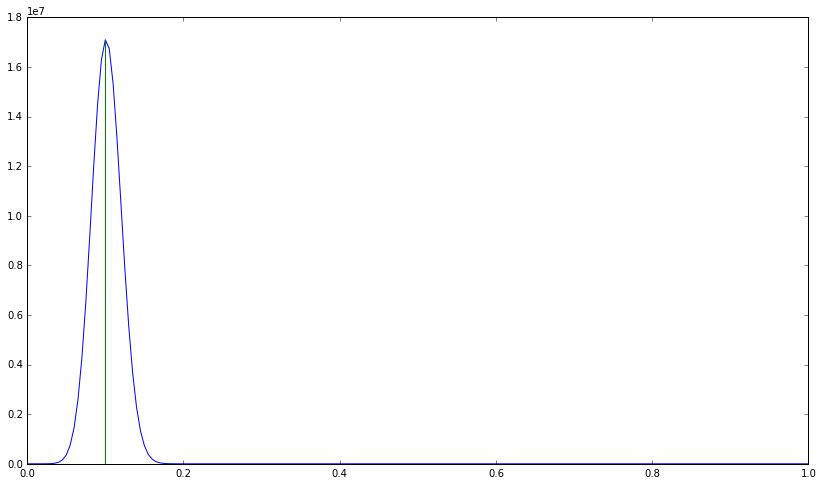

In [101]:
plt.plot(thetas, np.exp(values))
plt.plot([thetas[theta_max], thetas[theta_max]], [0, np.exp(values[theta_max])])
plt.show()

# $p_0$ and $p_1$ can be drawn from, imperfect classifier

In [130]:
from sklearn.neighbors import KNeighborsClassifier

n_samples = 100  # Goodness is controlled by having many training samples
X_p0 = p0.rvs(n_samples, random_state=0).reshape(-1, 1)
X_p1 = p1.rvs(n_samples, random_state=0).reshape(-1, 1)
X = np.vstack((X_p0, X_p1))
y = np.ones(len(X), dtype=np.int)
y[:n_samples] = 0

clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [131]:
from scipy.stats import gaussian_kde

n_samples = 10000
X_p0 = p0.rvs(n_samples, random_state=1).reshape(-1, 1)
X_p1 = p1.rvs(n_samples, random_state=1).reshape(-1, 1)
p0_r = gaussian_kde(clf.predict_proba(X_p0)[:, 1])
p1_r = gaussian_kde(clf.predict_proba(X_p1)[:, 1])

In [132]:
X_true = true.rvs(1000, random_state=0).reshape(-1, 1)
thetas = np.linspace(0., 1., num=201)
values = [likelihood(t, p0_r, p1_r, clf.predict_proba(X_true)[:, 1].reshape(-1, 1)) for t in thetas]
theta_max = np.argmax(values)
print("theta* = %.2f (L = %.2f)" % (thetas[theta_max], values[theta_max]))

theta* = 0.19 (L = 68.59)


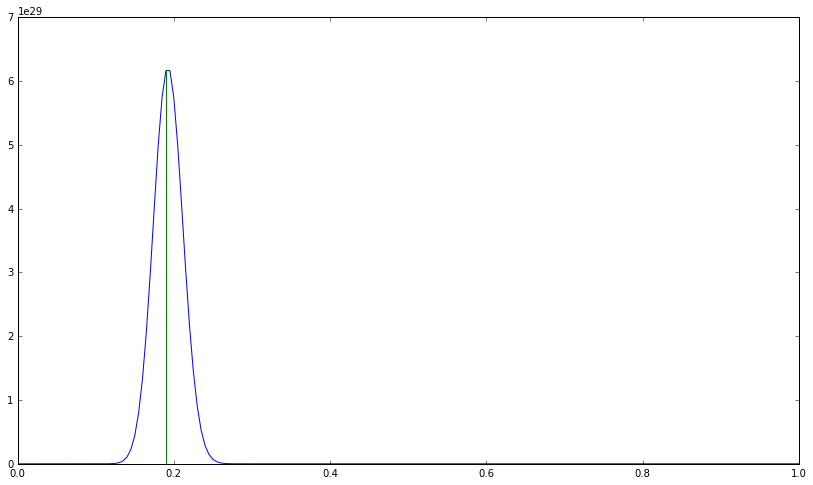

In [133]:
plt.plot(thetas, np.exp(values))
plt.plot([thetas[theta_max], thetas[theta_max]], [0, np.exp(values[theta_max])])
plt.show()